# Multi-dimensional scaling (MDS)

2019-10-29 Caroline Crockett  
2020-10-28 added a real example

## Group Formation and General Instructions
You may work individually, but we recommend that you work in pairs or groups of three. Find someone to work with and introduce yourself to them! One of you should copy the Google Document template and share the document with edit permissions with your group member(s): 
https://docs.google.com/document/d/19AHDD0C3hMsimWs4E1mY462h_LdGz6C3LrZ1v3bZfCk/template/preview (you must use your umich email address to access this google document). 


The Google Document will include your answers to a couple of questions that will be asked. For each question, pick someone to type up your **group's** response. After completing the response, the group member should sign their name by typing it below the answer. For the next question, have a different group member respond and sign their name in the same way. Keep rotating until all the questions have been answered.

The goal of this group exercise is to formulate your response as a group to the problem. When finished, **one** student in the group must submit a PDF of the google document to gradescope, entering the uniquenames of **all** students in the group. One group submits exactly one PDF, but we expect the PDF from different groups to differ. The deadline for submitting to gradescope will be announced on Canvas. Only submit the filled-in google document; do not submit a download of this Jupyter notebook. 

### Overview
This notebook helps to design and test the dist2locs function, which is an implementation of the multidimensional scaling problem. 

In [329]:
using Pkg; Pkg.add("JLD2")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [330]:
# packages needed 
using LinearAlgebra
using Random: seed!
using Plots
using Statistics
using JLD2

### Part 0: Create some test data 

Here, we form location coordinates, $c_j$, for $J$ sensors in the $d$ dimentional space. Based on these coordinates, we can calculate the distance matrix, $D$, which will be our input to the dist2locs function. Our goal will be to recover the $c_i$ variables, to within translation and rotation, given only the $D$ matrix and the dimension of the space, $d$. 

When solving MDS, we do not have the coordinates! However, by first forming the coordinates, we can test the MDS function. 

In [331]:
myplotter = (coords) -> scatter(coords[1,:],coords[2,:], xlabel="x", ylabel="y", label="", size=(300,300))

#51 (generic function with 1 method)

C = [-1 -2 7 6 -3 -8; 6 4 -9 -10 10 8]


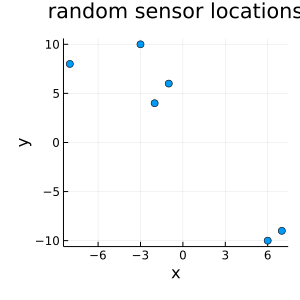

In [332]:
seed!(0)
J = 6; # we will randomly place J sensors 
d = 2; # each sensor will have d coordiantes (the sensors are in R^d space)

C = rand(-10:10,d,J) # each column of C is the location of one sensor
@show C 

# visualize the locations of our sensors
myplotter(C)
title!("random sensor locations")

In [333]:
# Create the distance matrix, D
# Here is a version with two for loops - this works, but it's inefficient 
D = zeros(J,J)
for i = 1:J
    for j = 1:J
        D[i,j] = norm(C[:,i]-C[:,j])
    end
end

# here's a more efficient way to compute D 
D = [norm(C[:,i]-C[:,j]) for i=1:J,j=1:J] 

# note that D is symmetric and the diagonal elements of D are all zero!

6×6 Matrix{Float64}:
  0.0       2.23607  17.0      17.4642    4.47214   7.28011
  2.23607   0.0      15.8114   16.1245    6.08276   7.2111
 17.0      15.8114    0.0       1.41421  21.4709   22.6716
 17.4642   16.1245    1.41421   0.0      21.9317   22.8035
  4.47214   6.08276  21.4709   21.9317    0.0       5.38516
  7.28011   7.2111   22.6716   22.8035    5.38516   0.0

### Part 1: Find a MDS solution 

Using the $D$ and $d$ variables defined, solve the MDS solution as outlined in the lecture notes (section 6.2). 

To force a unique solution (for the purposes of the autograder), we impose the following constraints:
* The $i$th column of $Xr$ is computed from the $i$th largest eigenpair of $C^T C$ (Reorder columns if needed. But there is a way to guarantee this without any reordering!)
* The centroid of the coordinates is zero 
* The largest magnitude element of each row of $Xr$ is positive (flip signs if needed) 

The point of this task is to develop the dist2locs code while testing steps along the way. 
In your submission, describe one additional test of the dist2locs code you would suggest doing.
The test can be for a one step in the dist2locs process or a test of the overall function.
You do not have to implement the test.

In [334]:
# TODO  
J = size(D,1)

# (1) First, find the matrix S, where s_ij = d_ij^2
# TODO: define S in terms of D here 
S = D .^2

# (1.5) S should be symmetric, but in the case of noise, it might not be! 
S = 0.5 * (S + S') # Force S to be symmetric (optional, but helps with numerical stability)

# (2) Next, de-mean
# TODO: define the de-meaning operator, P_orth, to project onto the othogonal complement of Range(1_J)
# TODO: Calculate G, the gram matrix, using P_orth 
P_orth = Diagonal(ones(J)) - (1/J) * ones(J) * ones(J)'
G = (-1 / 2) * P_orth * S * P_orth

# Check our work - both of these should display zero vectors (to within numerical precision) 
# if you defined P_orth correctly
display(mean(G,dims=1))
display(mean(G,dims=2))

1×6 Matrix{Float64}:
 1.18424e-15  -5.92119e-16  -9.4739e-15  …  4.73695e-15  -4.73695e-15

6×1 Matrix{Float64}:
  0.0
  2.3684757858670005e-15
 -2.3684757858670005e-15
 -2.3684757858670005e-15
  0.0
  0.0

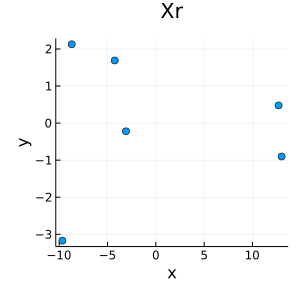

In [335]:
# TODO 

# (3) Compute relative coordinates
# TODO: Use the relationship between G and C to compute Xr 
# The $i$th column of $Xr$ should be computed from the $i$th largest eigenpair of $C^T C$ 
(U, s, V) = svd(G)
Xr = Diagonal( sqrt.(s[1:d])) * V[:,1:d]'
# Visualize the coordinates
myplotter(Xr)
title!("Xr")

In [308]:
Xr

2×6 Matrix{Float64}:
 -4.25306  -3.09228   12.7037    13.0179    -8.70387  -9.67235
  1.68996  -0.221219   0.477627  -0.901234   2.12612  -3.17125

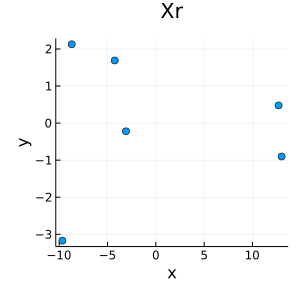

In [309]:
e = eigvals(G)
V = eigvecs(G)

d= min(d, count(e .>0))
inv_e = sort(e, rev=true)
V[:, indexin(inv_e[1:d], e)]
Xr =  V[:, indexin(inv_e[1:d], e)] * Diagonal(sqrt.(inv_e[1:d]))

Xr .-= mean(Xr, dims= 1)
myplotter(Xr')
title!("Xr")

In [305]:
Xr


6×2 Matrix{Float64}:
 -4.25306   1.68996
 -3.09228  -0.221219
 12.7037    0.477627
 13.0179   -0.901234
 -8.70387   2.12612
 -9.67235  -3.17125

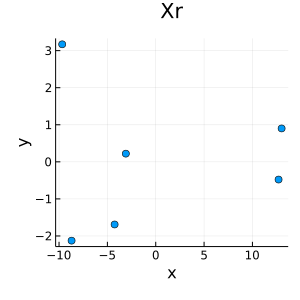

In [336]:
# TODO 

# (4) Get rid of the sign ambiguity 
# TODO: Force the largest magnitude element of each row of Xr to be positive 
Xr_abs = abs.(Xr)
for i in 1:d

    index = indexin(maximum(Xr_abs, dims=2)[i], Xr_abs[i,:])[1]
    a = Xr[i,:][index]
    if a < 0.0
        Xr[i, :] = -1 .* Xr[i, :]
    end
end

#findmax(abs.(Xr),1)[2]
# Xr_abs = abs.(Xr)
# Xr .*= sign.(Xr[findmax(Xr_abs, dims=1)[2]])
# Xr = Xr'
# myplotter(Xr)
    

# Visualize the updated coordinates
myplotter(Xr)
title!("Xr")

In [337]:
# Test our solution: do we get the same D if we recalculate it with Xr instead of C? 
Dhat = [norm(Xr[:,i]-Xr[:,j]) for i=1:J,j=1:J] 
norm(D-Dhat) # this should be (almost) zero if you did everything correctly! 

3.2348477410469754e-14

In [338]:
Xr

2×6 Matrix{Float64}:
 -4.25306  -3.09228   12.7037    13.0179    -8.70387  -9.67235
 -1.68996   0.221219  -0.477627   0.901234  -2.12612   3.17125

Now that you are done with the coding for part 1, make sure to complete the assignment: describe one additional test of the dist2locs code you would suggest doing.

### Part 2: Create the dist2locs function 
You now need to combine all the steps above into a single function. Make sure you define all variables you use. 

There is no separate submission for this part. You only need to submit your code to the autograder. 
Even if you are working in a group, every group member should submit the code to the autograder to receive credit. 

Hint: for submitting to autograder, make sure you include any packages you need.

In [353]:
# TODO 
# make sure to include any using statements before submitting to the autograder 
using LinearAlgebra
"""
Xr = dist2locs(D, d)

In:
* `D` is an `n x n` matrix such that `D[i, j]` is the distance from object `i` to object `j`
* `d` is the desired embedding dimension.

Out:
* `Xr` is an `d x n` matrix whose columns contains the relative coordinates of the `n` objects

Note: MDS is only unique up to rotation and translation,
so we enforce the following conventions on Xr in this order:
* [ORDER] `Xr[i,:]` corresponds to ith largest eigenpair of `C' * C`
* [CENTER] The centroid of the coordinates is zero
* [SIGN] The largest magnitude element of `Xr[i,:]` is positive
"""
function dist2locs(D, d)
    #set up
    J = size(D,1)
    S = D .^2
    #S = 0.5 * (S + S') 
    P_orth = Diagonal(ones(J)) - (1/J) * ones(J) * ones(J)'
    G = (-1 / 2) * P_orth * S * P_orth
    
#     e = eigvals(G)
#     V = eigvecs(G)

#     #Compute relative coordinates
#     d= min(d, count(e .>0))
#     inv_e = sort(e, rev=true)
#     Xr =  V[:, indexin(inv_e[1:d], e)] * Diagonal(sqrt.(inv_e[1:d]))

#     Xr .-= mean(Xr, dims= 1)
    
#     #Get rid of the sign ambiguity 
#     Xr_abs = abs.(Xr)
#     Xr .*= sign.(Xr[findmax(Xr_abs, dims=1)[2]])
#     Xr = Xr'

    (U, s, V) = svd(G)
    Xr = Diagonal( sqrt.(s[1:d])) * V[:,1:d]'
    Xr_abs = abs.(Xr)
    
    for i in 1:d

        index = indexin(maximum(Xr_abs, dims=2)[i], Xr_abs[i,:])[1]
        a = Xr[i,:][index]
        if a < 0.0
            Xr[i, :] = -1 .* Xr[i, :]
        end
    end
    return Xr
end


dist2locs

In [340]:
# Before submitting to the autograder, 
# test the function on our earlier example and make sure we get the same result 
norm(Xr - dist2locs(D, d)) # this should be zero! 

0.0

In [341]:
dist2locs(D, d)

2×6 Matrix{Float64}:
 -4.25306  -3.09228   12.7037    13.0179    -8.70387  -9.67235
 -1.68996   0.221219  -0.477627   0.901234  -2.12612   3.17125

### Part 3: Test out dist2locs function
After passing the autograder, complete the code below. 
Include the plots of the points estimated from D and Dnoisy in your report. 

You will need to download the ``distance_matrix.jld2`` file from Canvas and include it in the same folder as this script.

In [342]:
# Now apply to this distance matrix: 
@load "distance_matrix.jld2" D d
Dnoisy = D + mean(D)/2 .*randn(size(D)) 

@show size(D)

size(D) = (407, 407)


(407, 407)

In [343]:
d

2

In [344]:
r2 = dist2locs(D, d)

2×407 Matrix{Float64}:
 112.178   111.782   111.386   110.99  …  -109.44    -109.836   -110.232
  78.9806   70.9904   63.0002   55.01      -49.2049   -57.1951   -65.1853

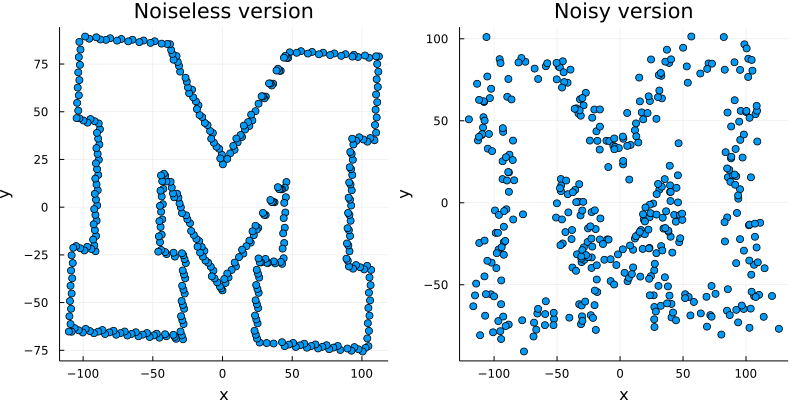

In [354]:
# TODO 

# TODO: apply your dist2locs to the D matrix above, save result in variable named Xr2
Xr2 = dist2locs(D, d)
# TODO: apply your dist2locs to the Dnoisy matrix above, save result in variable named Xr3
Xr3 = dist2locs(Dnoisy, d)
p1 = myplotter(Xr2); title!("Noiseless version")
p2 = myplotter(Xr3); title!("Noisy version")
plot(p1,p2,size=(800,400))

In [346]:
savefig("task4_part3.png")

### Optional 
How well does the dist2locs function do if you take out the following line? 

``S = 0.5 * (S + S')``

Is your solution still valid if you remove this line? If not, how would you make it valid?

### Code to make the example distance matrix 
This is mainly for future reference, and does not need to be given as part of the task file

In [347]:
using Images
using MIRT

LoadError: ArgumentError: Package MIRT not found in current path:
- Run `import Pkg; Pkg.add("MIRT")` to install the MIRT package.


In [348]:
img = load("M_logo.png") # this file needs to be in the same folder!

LoadError: ArgumentError: No file exists at given path: M_logo.png

In [349]:
mat = channelview(img) # convert to a matrix 
mat = dropdims(mapslices(mean, mat, dims=1),dims=1)
mat = [ones(3,size(mat,2)); mat] # this particular M logo needs a top border... 
jim(mat')

LoadError: UndefVarError: img not defined

In [350]:
imgrad = imedge(mat)[3] # just the magnitude of the gradient 
jim(imgrad' .> mean(imgrad))

LoadError: UndefVarError: mat not defined

In [351]:
points = findall(imgrad .> mean(imgrad))[1:8:end]
D = [norm([points[i][1] points[i][2]]-[points[j][1] points[j][2]]) for i=1:length(points), j=1:length(points)]
d = 2

LoadError: UndefVarError: imgrad not defined

In [352]:
@save "distance_matrix.jld2" D d